In [1]:
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler
from sklearn.manifold._locally_linear import barycenter_kneighbors_graph
import time
import os
import sys
sys.path.append("../dataprocess")
import dataprocess as dp

#### LLE functions

In [76]:
def performLLE(X: np.ndarray, k_NN: int, r: int, reg: float, transpose_flag: bool):
    """Perform Locally Linear Embedding with scikit-learn

    Args:
        X (np.ndarray): data matrix
        k_NN (int): number of nearest neighbors
        r (int): number of components to keep in the latent space
        reg (float): regularization parameter
        transpose_flag (bool): temporal vs spatial arrangement of data

    Returns:
        X_lle (LocallyLinearEmbedding): LLE object,
        containing embedded vectors
    """

    start = time.time()
    embedding = LocallyLinearEmbedding(
        n_components=r, n_neighbors=k_NN, reg=reg, random_state=42
    )
    if not transpose_flag:
        """the scikit-learn algorithm by default has a different data
        arrangement than our definition above
         By default it will reduce the size of the columns (temporal embedding),
         while our default is to reduce the size of the rows (spatial reduction)
         !!Note that if the tranpose_flag = True, i.e, we are doing temporal reduction,
         the RAM requirement is very high!!!
         Temporal reduction (transpose_flag = True) needs a much longer computational
         time than spatial reduction (transpose_flag = False)"""
        X = X.T
    X_lle = embedding.fit(X)
    end = time.time()

    print("Time elapsed for LLE embedding:", end - start, " s", flush=True)
    print("Shape after embedding:", X_lle.embedding_.shape, flush=True)

    return X_lle


def inverseTransform(
    X_test: np.ndarray,
    X_lle: LocallyLinearEmbedding,
    r_max: int,
    r_step: int,
    k_NN: int,
    reg: float,
    transpose_flag: bool,
):
    """Mapping back to the original space from the latent space and
       calculating reconstruction errors

    Args:
        X_test (np.ndarray): test data matrix
        X_lle (LocallyLinearEmbedding): LLE object
        r_max (int): max number of components used for reconstruction
        r_step (int): mode number increment for calculating the reconstruction error
        k_NN (int): number of nearest neighbors used for LLE
        reg (float): regularization parameter
        transpose_flag (bool): temporal vs spatial arrangement of data

    Returns:
        X_reconstructed (np.ndarray): reconstructed data matrix with r_max modes
        err_rec (np.ndarray): vector containing the reconstruction error for 1 to r_max modes    """

    err_rec = np.zeros(len(range(1, r_max + 1, r_step)))

    if not transpose_flag:
        # the scikit-learn algorithm by default has a different data
        # arrangement than our definition
        X_test = X_test.T
    X_test_trans = X_lle.transform(X_test)
    i = 0
    for r in range(1, r_max + 1, r_step):
        # get the first r components of the embedded vectors
        Y = X_test_trans[:, 0:r]
        # calculate the weights for expressing each point in the embedded space
        # as a linear combination of its neighbors
        W = barycenter_kneighbors_graph(Y, n_neighbors=k_NN, reg=reg)
        # reconstruct the data points in the high dimensional space from its neighbors
        # using the weights calculated based on the embedded space
        X_reconstructed = W.dot(X_test)
        # calculate reconstruction error over all snapshots using Frobenius norm
        err_rec[i] = np.linalg.norm(X_test - X_reconstructed) / np.linalg.norm(X_test)
        i += 1
    return X_reconstructed, err_rec

#### Parameters

In [77]:
# Mesh
nx = 227  # X-direction nodes
ny = 120  # Y-direction nodes
# Domain:
Lx = 17.665369  # Lx (Size of the box in x-direction)
Ly = 9.0  # Ly (Size of the box in y-direction)
# Cylinder coordinates:
X_0 = 2.66537  # X coordinate of the center
Y_0 = 4.5  # Y coordinate of the center
r = 0.5  # Cylinder radius

mesh = dp.Mesh(nx, ny, Lx, Ly, X_0, Y_0, r)

# Data path
re = 100
train_input_dir = "../data/modV_train/"
test_input_dir = "../data/modV_test/"
input_filename = f'modV_crop_re{re}.csv'

#### Data pre-processing

In [ ]:
''' Read velocity data
  X - velocity module
 rows of X correspond to velocity components at spatial locations
 columns of X correspond to timesteps
     t_1 t_2.  .  t_n
 X = [u  u  .  .  .]  (x_1,y_1)
     [v  v  .  .  .]  (x_1,y_1)
     [w  w  .  .  .]  (x_1,y_1)
     [u  u  .  .  .]  (x_2,y_2)
     [v  v  .  .  .]  (x_2,y_2)
     [w  w  .  .  .]  (x_2,y_2)
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
     [.  .  .  .  .]   .
'''
X_train = dp.read_X_csv(os.path.join(train_input_dir, input_filename))
X_test = dp.read_X_csv(os.path.join(train_input_dir, input_filename))

# Scale data
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

n, m = X_train.shape

print("Data matrix X is n by m:", n, "x", m, flush=True)

# Create mesh class instance
mesh = dp.Mesh(nx, ny, Lx, Ly, X_0, Y_0, r)
# Erase cylinder from snapshot
X_train_filt = dp.erase_cyl(X_train, mesh)
X_test_filt = dp.erase_cyl(X_test, mesh)

#### Perform LLE

In [ ]:
# k_NN - number of nearest neighbors used for LLE (30 for spatial reduction, 300 for temporal reduction)
# r_max - number of components to be kept in the latent space
# reg - regularization parameter
k_NN = 10
r_max = 12
reg = 1e-9
# transpose_flag - temporal vs spatial arrangement of data
#        if True: temporal size of the data will be reduced (leading to spatial modes)
#        if False: spatial size of the data will be reduced (NOT leading to spatial modes)
transpose_flag = False

X_lle = performLLE(X_train_filt, k_NN, r_max, reg, transpose_flag)

Time elapsed for LLE embedding: 2.160891532897949  s
Shape after embedding: (1000, 12)


##### Save and plot LLE modes

In [ ]:
# save modes in csv and png files
save_flag = True
if save_flag:
    outfile_dir = "modes/"
    modesToSave = r_max
    if modesToSave > X_lle.embedding_.shape[1]:
        modes = X_lle.embedding_.shape[1]
        print("Max number of modes is", X_lle.embedding_.shape[1])
    else:
        dp.save_modes(X_lle, outfile_dir, modesToSave, mesh)

##### Data reconstruction

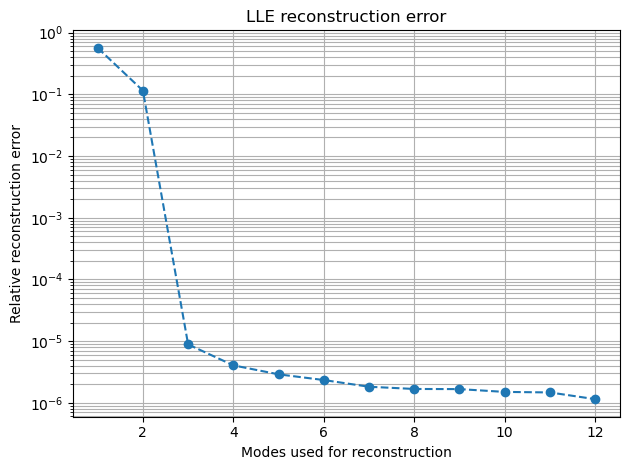

In [ ]:
# Max number of components and step for postprocess
r_max = 12
r_step = 1

X_reconstructed, err_rec = inverseTransform(
    X_test_filt, X_lle, r_max, r_step, k_NN, reg, transpose_flag
)
# Save reconstruction errors for further post-processing
np.savetxt("error_rec_LLE_s.csv", err_rec, delimiter=",")

dp.plot_save_reconst(err_rec, r_max, r_step, "LLE")